In [27]:
import rasterio
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.crs import CRS
import shapely
from affine import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling

from atlite.gis import ExclusionContainer, shape_availability

In [18]:
def get_bounding():
    
    rectx1 = -12
    rectx2 = 44
    recty1 = 33
    recty2 = 72
    
    polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
    )
    
    polygon=shapely.segmentize(polygon, max_segment_length=0.5)
    
    b=gpd.GeoDataFrame(geometry=[polygon],crs="EPSG:4326")
 
    return b.to_crs("EPSG:3035")

In [6]:
def plot_eligible_area(ax, tiff_path, europe, title):
    excluder_wind_onshore = ExclusionContainer()

    # Ensuring the correct CRS for full_europe
    full_europe = (
        europe
        .assign(col='a')
        .dissolve(by='col')
        .geometry
    )

    # Open the TIFF file and ensure CRS matches
    with rasterio.open(tiff_path) as src:
        if full_europe.crs != src.crs:
            full_europe = full_europe.to_crs(src.crs)

    # Bufffer geometry ensuring CRS consistency
    full_europe = full_europe.to_crs(excluder_wind_onshore.crs)

    # Example mask and transformation logic
    excluder_wind_onshore.add_raster(tiff_path)
    masked, transform = shape_availability(full_europe, excluder_wind_onshore)
    eligible_share = (masked.sum() * excluder_wind_onshore.res**2 / full_europe.geometry.item().area)
    
    # Plot the eligible area in a subplot
    show(masked, transform=transform, cmap='Greens', ax=ax)
    full_europe.plot(ax=ax, edgecolor='k', color='None')
    europe.to_crs(excluder_wind_onshore.crs).boundary.plot(ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(f'{title} Eligible area (green) {eligible_share * 100:2.2f}%')

In [ ]:
if convert_slope == 'Yes':
    minx, miny, maxx, maxy = get_bounding().total_bounds
    # Open the existing raster
    with rasterio.open(slope) as src:
        # Calculate transform of the new intended output dimensions
        new_transform = Affine.translation(minx, maxy) * Affine.scale(
            (maxx - minx) / src.width,
            (miny - maxy) / src.height)

        # Calculate new width and height
        new_width = int((maxx - minx) / new_transform.a)
        new_height = int((maxy - miny) / -new_transform.e)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': CRS.from_epsg(3035),
            'transform': new_transform,
            'width': new_width,
            'height': new_height,
            'compress': 'lzw'  # Add LZW compression
        })

        with rasterio.open('/home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=new_transform,
                    dst_crs=CRS.from_epsg(3035),
                    resampling=Resampling.nearest)

In [29]:
codes = {
    5: [
        {'buffer': 0},
    ],
}


with rasterio.open("/home/oskar/shared_input/geodata/onshore/corine.tif") as vrt:
    minx, miny, maxx, maxy = get_bounding().total_bounds
    new_transform = Affine.translation(minx, maxy) * Affine.scale(
            (maxx - minx) / vrt.width,
            (miny - maxy) / vrt.height)

    new_width = int((maxx - minx) / new_transform.a)
    new_height = int((maxy - miny) / -new_transform.e)
    d=vrt.read(1)
    for code, buffer in codes.items():
        d[d==code]=1

    d[d!=1]=0

    kwargs = vrt.meta.copy()
    kwargs.update({
        'crs': CRS.from_epsg(3035),
        'transform': new_transform,
        'width': new_width,
        'height': new_height,
        'nodata': 255,
        'dtype': 'uint8',
        'compress': 'lzw'  # Add LZW compression
    })
    #meta=vrt.meta
    #meta["dtype"]='uint8'
    #meta["compress"]="LZW"
    #meta["nodata"]=255

    with rasterio.open('corine_ports_0m.tif','w',**kwargs) as dst:
        for i in range(1, vrt.count + 1):
            reproject(
                source=rasterio.band(d, i),
                destination=rasterio.band(dst, i),
                src_transform=d.transform,
                src_crs=d.crs,
                dst_transform=new_transform,
                dst_crs=CRS.from_epsg(3035),
                resampling=Resampling.nearest)

AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'

In [7]:
aggregated_regions = [
    "AT", "BE", "BG", "CH", "CZ", "DE",
    "DK", "EE", "ES", "FI", "FR", "UK",
    "GR", "HR", "HU", "IE", "IT", "LT",
    "LU", "LV", "NL", "NO", "PL", "PT", 
    "RO", "SE", "SI", "SK",
]

In [10]:
europe = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/onshore/shapes/NUTS_RG_10M_2021_4326.geojson')
    .query("NUTS_ID == @aggregated_regions")
    .set_index(["NUTS_ID"])
    .loc[:,['geometry']]
)

In [11]:
# The square outer boundaries of Europe to consider, because we have downloaded ERA5 for this extent:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 72

In [12]:
polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)

/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


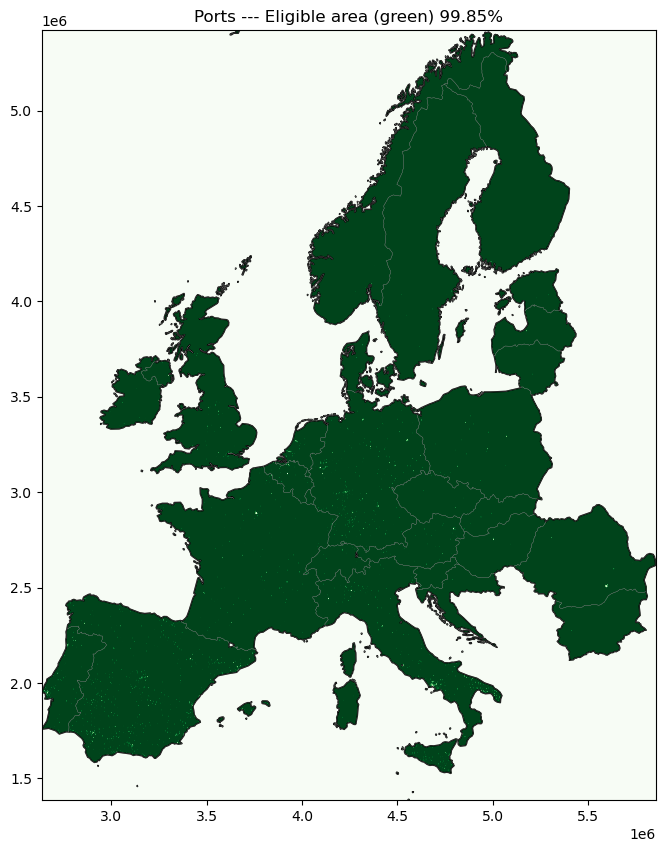

In [17]:
fig, ax = plt.subplots(1,1,figsize=(16,10))

plot_eligible_area(ax, 'corine_ports_0m.tif', europe, 'Ports ---')